稀疏化比例 epsilon = 0.1

RAW_SCORE 这个文件中 对于每个mu值（可以看作第零个坐标）

第一个坐标是样本编号

第二个坐标 0 代表稀疏化的网络 1 代表原网络

第三个坐标是方法 ['Euclidean NMI', 'Spherical NMI', 'Euclidean ECS', 'Spherical ECS']

RAW_QF 这个文件中，对于每个mu值（可以看作第零个坐标）

第一个坐标是样本编号

第二个坐标 0 代表稀疏化的网络 1 代表原网络

In [1]:
#隐藏警告
import warnings
warnings.filterwarnings('ignore')

In [2]:
def generate_ppm(q, comm_size, deg_avg, mu):
    n = q*comm_size # total number of nodes
    # Calculate p_out and p_in
    p_out = mu*deg_avg/n
    p_in = (deg_avg - (n - n / q) * p_out) / (n / q - 1)
    #print(f'p_out={p_out}, p_in={p_in}')
    if p_out < 0 or p_out > 1 or p_in < 0 or p_in > 1:
        raise ValueError("Calculated probability is out of the valid range (0, 1).")
    sizes = [n // q] * q  

    # Probability matrix (within and between blocks)
    p_matrix = [[p_in if i == j else p_out for j in range(q)] for i in range(q)]

    # Generate the PPM graph using the SBM generator
    G = nx.stochastic_block_model(sizes, p_matrix, seed=42)
    return G

The average degree of the graph is: 25.08


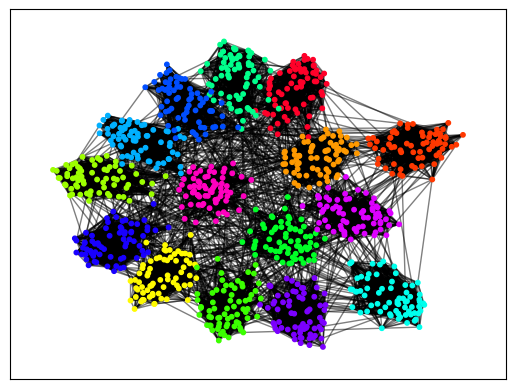

In [3]:
import numpy as np
import networkx as nx
from networkx.generators.community import LFR_benchmark_graph

import matplotlib.pyplot as plt

# Parameters for the Planted Partition Model
number_of_comm = 15           # Number of communities
comm_size = 68  # Size of communities
n = number_of_comm*comm_size          # Total number of nodes
deg_avg = 25  # Average degree of the whole network
mu = 0.05  # mixing parameter


G = generate_ppm(number_of_comm, comm_size, deg_avg, mu)


# Calculate the true average degree
avg_degree = sum(dict(G.degree()).values()) / n
print(f"The average degree of the graph is: {avg_degree:.2f}")

intrinsic_membership = list(nx.get_node_attributes(G, 'block').values())

# 对于每个节点，按照其 intrinsic_membership 着色画图
import matplotlib
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,
                      pos,
                      node_size=10,
                      cmap=matplotlib.colormaps.get_cmap('gist_rainbow'),
                      node_color=intrinsic_membership
                      )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [4]:
import sys
import os

# 将子目录添加到 sys.path
current_dir = os.getcwd()
sys.path.append(os.path.join(os.path.join(current_dir),'EffectiveResistanceSampling'))

from EffectiveResistanceSampling.Network import *
import numpy as np
    
import networkx as nx
import scipy.sparse

def to_networkx(self):
    if isinstance(self.graph, scipy.sparse.csr.csr_matrix):
        return nx.from_scipy_sparse_matrix(self.graph)
    else:
        return nx.from_numpy_array(self.graph)

In [5]:
# This is the function for Laplacian Eigenmap using Cupy. The presence of GPU is required.

import numpy as np
import networkx as nx
import cupy as cp

def lap_cupy(graph, dim):
    """
    Compute the Laplacian embedding of a graph using CuPy.

    Parameters:
    graph (networkx.classes.graph.Graph): The input graph.
    dim (int): The dimension of the embedding.

    Returns:
    numpy.ndarray: The Laplacian embedding of the graph.
    """
    # Check inputs
    assert isinstance(graph, nx.Graph), "Input graph must be a NetworkX graph."
    assert isinstance(dim, int) and dim > 0, "Input dim must be a positive integer."
    assert dim < graph.number_of_nodes(), "Input dim must be less than the number of nodes in the graph."

    # Convert the adjacency matrix of the graph to a CuPy array
    A = cp.asarray(nx.adjacency_matrix(graph, nodelist=graph.nodes(), weight='weight').toarray(), dtype=cp.float64)

    # Compute L1 normalization along axis 1 (rows)
    row_sums = cp.linalg.norm(A, ord=1, axis=1)
    P = A / row_sums.reshape(-1, 1)

    # Compute the eigenvalues and eigenvectors of I_n - P
    I_n = cp.eye(graph.number_of_nodes())
    w, v = cp.linalg.eigh(I_n - P) # v 的每列是一个特征向量

    # Sort the eigenvectors by the real part of the eigenvalues
    v = v[:, cp.argsort(w.real)]
    
    v_return = v[:, 1:(dim+1)].get().real

    # Return the embedding
    return v_return  # Explicitly convert to NumPy array using .get()

In [6]:
### KMeans Clustering using Euclidean and Spherical metrics
### Using NMI and ECSim for comparison
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import normalize
from sklearn.metrics import normalized_mutual_info_score
import clusim.sim as sim
from clusim.clustering import Clustering


def euclid_membership(K, points):
    euc_kmeans = KMeans(n_clusters=K, n_init=10)
    euc_kmeans.fit(points)

    evala_euclid_membership = euc_kmeans.labels_
    return evala_euclid_membership

def cosine_membership(K, points):
    normalized_points = normalize(points)
    cos_kmeans = KMeans(n_clusters=K, n_init=10)
    cos_kmeans.fit(normalized_points)

    evala_cosine_membership = cos_kmeans.labels_
    return evala_cosine_membership

def calculate_score(evala, intr_list, K):
# evala is the embedding vectors
# intr_list is the intrinsic community strucuture
# K is the number of clusters in Kmeans
    return_val = [] # 首先准备好返回值 

    intr_clus = Clustering({i: [intr_list[i]] for i in range(len(intr_list))})

    evala_euclid_membership = euclid_membership(K, evala)

    evala_cosine_membership = cosine_membership(K, evala)

    ## compare with intrinsic community structure using NMI
    return_val.append(normalized_mutual_info_score(evala_euclid_membership, intr_list, average_method='arithmetic'))
    return_val.append(normalized_mutual_info_score(evala_cosine_membership, intr_list, average_method='arithmetic'))
    
    
    evala_euclid_clustering = Clustering(elm2clu_dict={i: [evala_euclid_membership[i]] for i in range(len(evala_euclid_membership))})
    evala_cosine_clustering = Clustering(elm2clu_dict={i: [evala_cosine_membership[i]] for i in range(len(evala_cosine_membership))})
    
    ## compare with intrinsic community structure using ECSim
    evala_euclid_similarity = sim.element_sim(intr_clus, evala_euclid_clustering, alpha=0.9)
    evala_cosine_similarity = sim.element_sim(intr_clus, evala_cosine_clustering, alpha=0.9)
    return_val.append(evala_euclid_similarity)
    return_val.append(evala_cosine_similarity)
    
    return return_val

In [7]:
import numpy as np

step_total  = 18
step_size = 0.05
MU = np.arange(step_size, step_size*step_total+0.01, step_size)

SAMPLE = 100

stat = np.zeros((step_total, 2, 4))
qf_ratio = np.zeros((step_total))

K = 15

RAW_SCORE={}
RAW_QF={}

In [8]:
import numpy as np
import networkx as nx
from concurrent.futures import ProcessPoolExecutor


def process_mu(mu):
    raw_score_mu = np.zeros((SAMPLE, 2, 4))
    raw_qf_mu = np.zeros((SAMPLE, 2))
    for i in range(SAMPLE):
        G = generate_ppm(number_of_comm, comm_size, deg_avg, mu)

        G = nx.Graph(G)
        selfloop_edges = list(nx.selfloop_edges(G))
        G.remove_edges_from(selfloop_edges)

        intrinsic_membership = list(nx.get_node_attributes(G, 'block').values())

        edge_list = list(G.edges())
        edge_list = np.array(edge_list)

        edge_weights = nx.get_edge_attributes(G, 'weight')
        edge_weights = np.array(edge_weights)

        edge_weights = [edge_weights[edge] if edge in edge_weights else 1 for edge in edge_list]

        Gn = Network(edge_list, edge_weights)

        epsilon = 0.1
        method = 'spl'
        Effective_R = Gn.effR(epsilon, method)

        q = 10000
        seed = 2024
        
        while(True):
            Gn_Sparse = Gn.spl(q, Effective_R, seed=seed)

            G_sparse = to_networkx(Gn_Sparse)
            if nx.is_connected(G_sparse):
                break           
        A = np.asarray(nx.adjacency_matrix(G, nodelist=G.nodes(), weight='weight').toarray(), dtype=np.float64)
        embedding_sparse = lap_cupy(G_sparse, K)
        embedding_original = lap_cupy(G, K)
        
        #score_sparse_orth = calculate_score(
        #    compute_orthogonal_components(G, embedding_sparse), intrinsic_membership, len(np.unique(intrinsic_membership)))
        #raw_score_mu[i, 0] = score_sparse_orth
        score_sparse = calculate_score(embedding_sparse, intrinsic_membership, len(np.unique(intrinsic_membership)))
        raw_score_mu[i, 0] = score_sparse
        
        quadratic_form_sparse = 0
        for k in range(embedding_sparse.shape[1]):
            vk = embedding_sparse[:, k]
            for s in range(A.shape[0]):
                for t in range(A.shape[1]):
                    quadr = A[s, t] * (vk[s] - vk[t]) ** 2
                    quadratic_form_sparse += quadr
        raw_qf_mu[i,0] = quadratic_form_sparse
        #print(quadratic_form_sparse)
        
        
        score_original = calculate_score(embedding_original, intrinsic_membership, len(np.unique(intrinsic_membership)))
        raw_score_mu[i, 1] = score_original

        quadratic_form_original = 0
        for k in range(embedding_original.shape[1]):
            vk = embedding_original[:, k]
            for s in range(A.shape[0]):
                for t in range(A.shape[1]):
                    #print(A[s, t])
                    quadr = A[s, t] * (vk[s] - vk[t]) ** 2
                    quadratic_form_original += quadr
        #print(quadratic_form_original)
            
        raw_qf_mu[i,1] = quadratic_form_original
        
        print(i)

    return mu, raw_score_mu, np.mean(raw_score_mu, axis=0), raw_qf_mu

In [9]:
with ProcessPoolExecutor() as executor:
    results = list(executor.map(process_mu, MU))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
1
2
1
1
1
2
2
3
3
3
3
3
3
3
2
3
3
2
3
3
4
2
4
4
4
4
3
4
2
2
2
4
4
4
4
3
3
5
4
5
5
5
5
5
5
4
5
5
5
3
3
3
3
6
6
4
6
6
6
5
6
6
4
6
6
6
5
7
7
7
7
7
7
7
6
5
4
7
7
4
4
4
7
5
6
8
8
8
8
8
8
8
7
8
8
6
8
9
9
5
9
9
7
9
6
9
5
9
5
5
9
8
9
9
10
10
10
10
7
10
10
108

6
10
7
10
9
11
11
10
6
11
6
11
6
11
11
11
8
9
11
11
12
10
12
12
12
12
11
8
7
12
12
12
7
7
7
10
9
12
13
13
13
13
13
11
12
13
13
9
8
13
14
14
14
13
14
11
14
10
14
14
12
13
8
8
8
14
15
15
15
15
14
10
15
12
15
15
9
13
14
11
15
16
16
16
16
15
9
9
9
16
16
16
13
15
14
11
17
12
16
10
17
17
17
16
17
17
17
16
14
15
10
18
10
18
10
18
17
18
12
17
18
18
13
18
11
17
19
19
16
15
19
19
18
19
19
18
19
13
11
11
11
14
18
20
20
20
20
19
17
16
12
20
20
19
20
21
19
21
14
21
21
20
15
12
21
21
18
12
12
21
17
20
13
22
22
20
22
22
21
22
22
15
19
22
16
21
18
23
23
13
23
13
23
22
13
21
23
23
14
23
20
22
24
17
24
16
24
24
19
23
22
24
24
24
14
23
21
14
25
14
15
25
25
25
24
18
20
2523

2

In [10]:
for mu, raw_score_mu, mean_score, raw_qf_mu in results:
    RAW_SCORE[mu] = raw_score_mu
    RAW_QF[mu] = raw_qf_mu
    stat[int(mu / step_size + 0.001) - 1] = mean_score
    
    ratios = raw_qf_mu[:, 0] / raw_qf_mu[:, 1]
    qf_ratio[[int(mu / step_size + 0.001) - 1]] = np.mean(ratios)

print("并行计算完成")

并行计算完成


In [11]:
import pickle

# 将 RAW_SCORE 存储到文件
with open('data/ppm_lap_raw_score.pkl', 'wb') as file:
    pickle.dump(RAW_SCORE, file)

print("RAW_SCORE 已成功存储到 ppm_lap_raw_score.pkl 文件中")

# 将 RAW_QF 存储到文件
with open('data/ppm_lap_raw_qf.pkl', 'wb') as file:
    pickle.dump(RAW_QF, file)

print("RAW_QF 已成功存储到 ppm_lap_raw_qf.pkl 文件中")

RAW_SCORE 已成功存储到 sbm_raw_score.pkl 文件中
RAW_QF 已成功存储到 sbm_raw_score.pkl 文件中


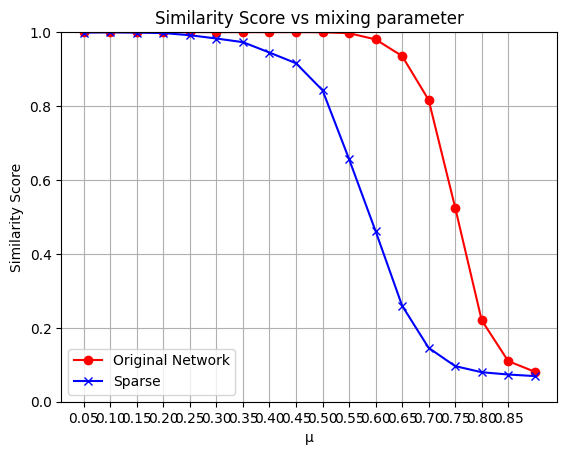

In [12]:
import numpy as np
import matplotlib.pyplot as plt

method = 2


# 绘制每列的折线图
plt.plot(stat[:, 1, method], label='Original Network', color='r', marker='o')  # 红色曲线
plt.plot(stat[:, 0, method], label='Sparse', color='b', marker='x')  # 蓝色曲线

# 添加网格
plt.grid(True)

# 添加图例并设置位置
plt.legend(loc='best')

# 添加标签和标题
x_labels = np.arange(0.05, step_total*step_size, 0.05)
plt.xticks(ticks=np.arange(len(x_labels)), labels=[f'{x:.2f}' for x in x_labels])
plt.xlabel('μ')
plt.ylabel('Similarity Score')
plt.title('Similarity Score vs mixing parameter')
plt.ylim(0, 1)

# 显示图形
plt.show()

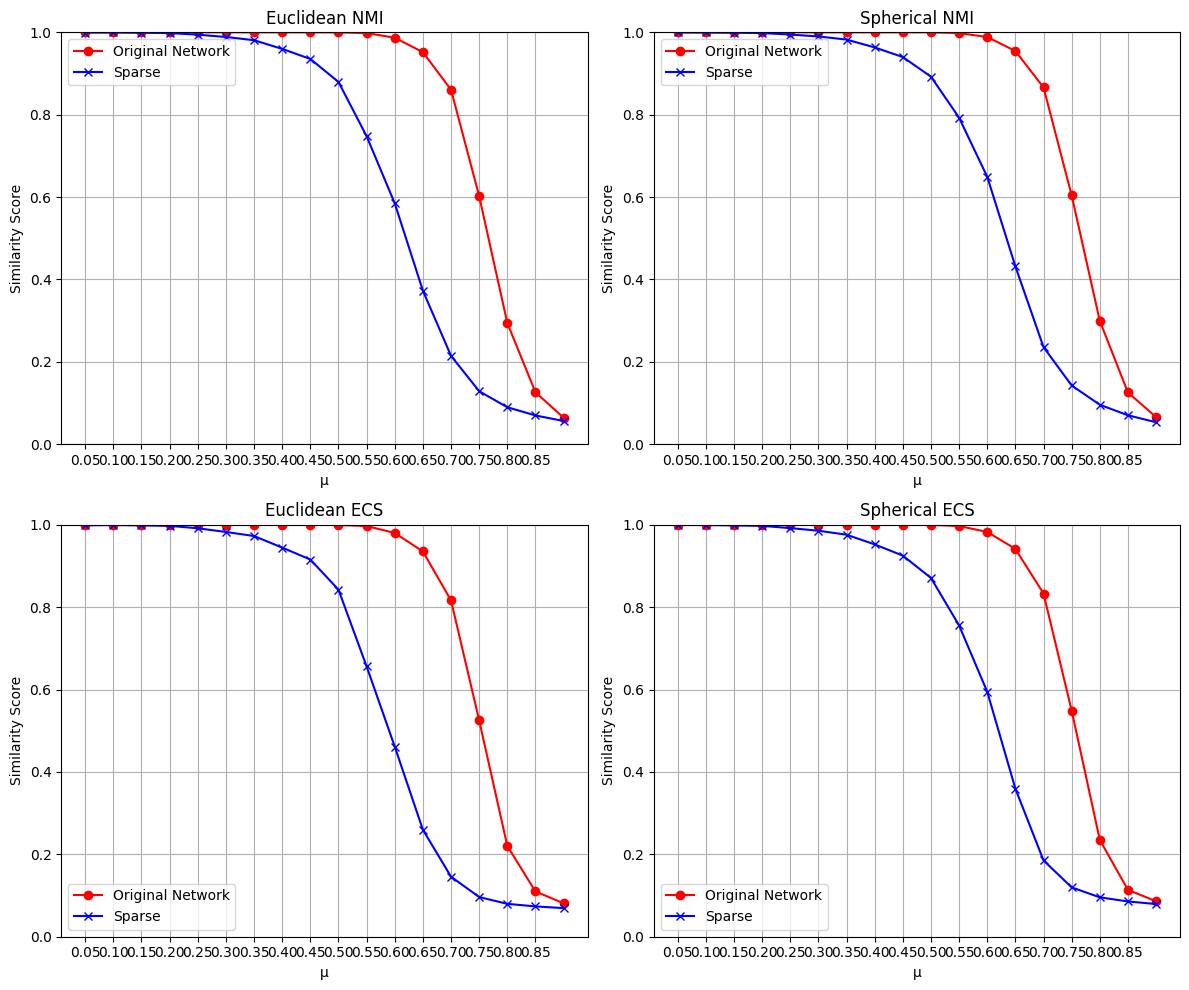

In [13]:
import numpy as np
import matplotlib.pyplot as plt


methods = [0, 1, 2, 3]
titles = ['Euclidean NMI', 'Spherical NMI', 'Euclidean ECS', 'Spherical ECS']

# 创建 2x2 网格布局
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# 绘制每个 method 的折线图
for i, method in enumerate(methods):
    ax = axs[i // 2, i % 2]
    ax.plot(stat[:, 1, method], label='Original Network', color='r', marker='o')  # 红色曲线
    ax.plot(stat[:, 0, method], label='Sparse', color='b', marker='x')  # 蓝色曲线
    
    # 添加网格
    ax.grid(True)
    
    # 添加图例并设置位置
    ax.legend(loc='best')
    
    # 添加标签和标题
    x_labels = np.arange(0.05, step_total*step_size, 0.05)
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_xticklabels([f'{x:.2f}' for x in x_labels])
    ax.set_xlabel('μ')
    ax.set_ylabel('Similarity Score')
    ax.set_title(titles[i])
    # 设置 y 轴范围
    ax.set_ylim(0, 1)  # 这里设置 y 轴的范围为 0 到 1，可以根据实际数据调整
    
# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()